# 4. 파이토치로 구현한 AutoEncoder
오토인코더는 레이블이 없이 특징을 추출하는 비지도학습 인공신경망입니다. 그 중에서도 오토인코더는 x를 입력받아 x를 예측하도록 설계돼있는 신경망입니다. 오찻값도 x를 얼마나 복원했는지를 나타내는 복원오차(정보손실값)을 사용합니다. 
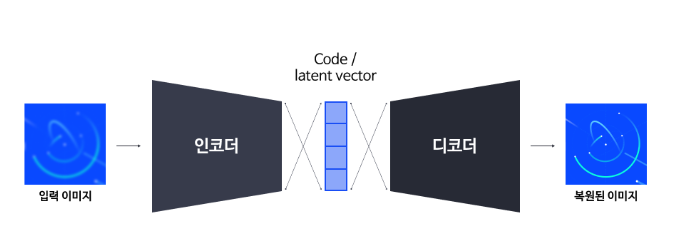
중간 계층을 latent space라 하며 이는 작은 차원에 x를 압축시킨것으로 병목현상이 일어나 정보는 줄지만 특징이 압축되는 점이 있습니다. latent space을 중심으로 앞은 인코더 뒤는 디코더라합니다.  
오토인코더는 주로 복잡한 비선형 데이터의 차원을 줄이거나 비정상 거래 검출, 데이터 복원,의미 추출 등에 사용됩니다.

## 4-1. Fashion MNIST 데이터셋 오토인코더 수행

Using device:  cuda
[Epoch 1]


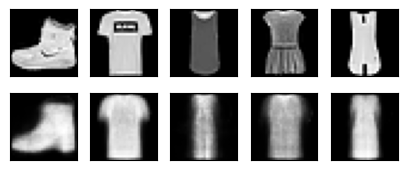

[Epoch 2]


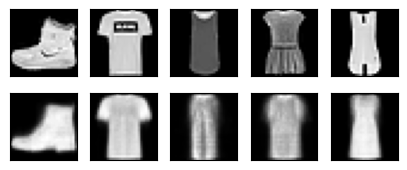

[Epoch 3]


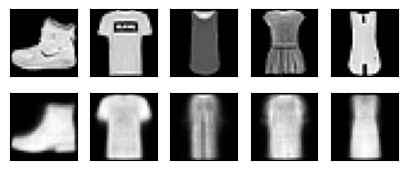

[Epoch 4]


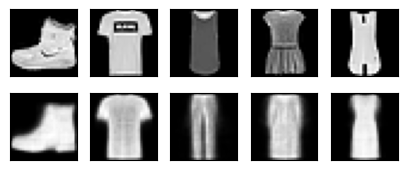

[Epoch 5]


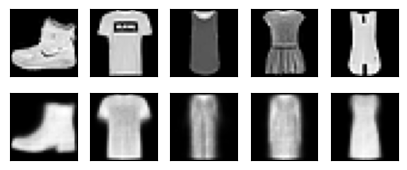

[Epoch 6]


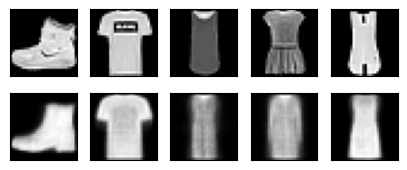

[Epoch 7]


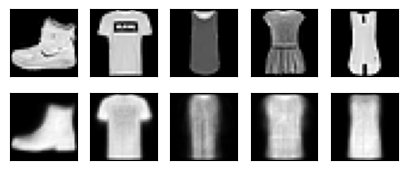

[Epoch 8]


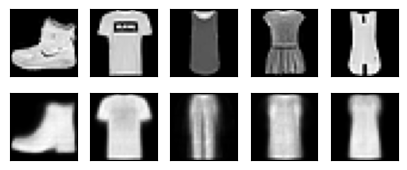

[Epoch 9]


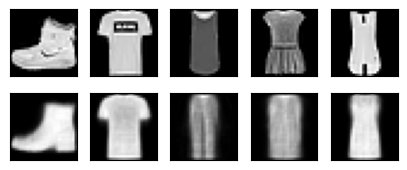

[Epoch 10]


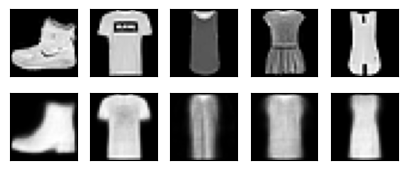

In [4]:
import torch
import torchvision
from torchvision import transforms,datasets
import torch.nn.functional as F
from torch import nn, optim
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

EPOCHS = 10
BATCH_SIZE = 64
LEARNING_RATE = 0.01
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using device: ", DEVICE)

trainset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
## numworkers는 데이터를 읽어올때 몇개의 프로세스를 사용할지를 정하는 것이다.
## 이것도 파라미터 튜닝 요소 중 하나로 적당한 값을 조정해서 가장 빠르게 돌릴 수 있게 해야한다.
## 보통 코어갯수의 절반 사용

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3)
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

autoencoder = AutoEncoder().to(DEVICE)
optimizer = optim.Adam(autoencoder.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()

view_data = trainset.data[:5].view(-1, 28*28)
view_data = view_data.type(torch.FloatTensor)/255.

def train(autoencoder, trainloader):
    autoencoder.train()
    for step,(x,label) in enumerate(trainloader):
        x = x.view(-1, 28*28).to(DEVICE)
        y = x.view(-1, 28*28).to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        encoded,decoded = autoencoder(x)
        loss = criterion(decoded, y)
        loss.backward()
        optimizer.step()

for epoch in range(1, EPOCHS+1):
    train(autoencoder, trainloader)
    test_x = view_data.to(DEVICE)
    _, decoded_data = autoencoder(test_x)
    f, a = plt.subplots(2, 5, figsize=(5, 2))
    print("[Epoch {}]".format(epoch))
    for i in range(5):
        img = np.reshape(view_data.data.numpy()[i], (28, 28))
        a[0][i].imshow(img, cmap='gray')
        a[0][i].set_xticks(())
        a[0][i].set_yticks(())
    for i in range(5):
        img = np.reshape(decoded_data.to("cpu").data.numpy()[i], (28, 28))
        a[1][i].imshow(img, cmap='gray')
        a[1][i].set_xticks(())
        a[1][i].set_yticks(())
    plt.show()


## 4-2. 잠재변수 확인하기

In [5]:
# 잠재변수를 3차원으로 시각화
view_data = trainset.data[:200].view(-1, 28*28)
view_data = view_data.type(torch.FloatTensor)/255.
test_x = view_data.to(DEVICE)
encoded_data, _ = autoencoder(test_x)
encoded_data = encoded_data.to("cpu")
CLASSES = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}
fig = plt.figure(figsize=(10, 8))
ax = Axes3D(fig)

X=encoded_data.data[:, 0].numpy() 
Y=encoded_data.data[:, 1].numpy()
Z=encoded_data.data[:, 2].numpy()
labels = trainset.targets[:200].numpy()

for x, y, z, s in zip(X, Y, Z, labels):
    name = CLASSES[s]
    color = cm.rainbow(int(255*s/9))
    ax.text(x, y, z, name, backgroundcolor=color)

ax.set_xlim(X.min(), X.max())
ax.set_ylim(Y.min(), Y.max())
ax.set_zlim(Z.min(), Z.max())
plt.show()
## 여기서 알 수 있는건 같은 레이블을 가진 이미지의 잠재변수는 확연히 서로 모인다는 것
## 그리고 비슷한 의미(상의,신발 등)의 이미지들은 가깝다
## 이것을 이용해서 비지도학습으로 레이블링을 할 수 있다.

<Figure size 1000x800 with 0 Axes>

## 4-3. 오토인코더로 망가진 이미지 복원

[Epoch 1] loss:0.02439144267035382
[Epoch 2] loss:0.023674343873474644
[Epoch 3] loss:0.02367918026139106
[Epoch 4] loss:0.023517591531263357
[Epoch 5] loss:0.02346665414371915
[Epoch 6] loss:0.023524551803289828
[Epoch 7] loss:0.023339111260624965
[Epoch 8] loss:0.02337450854408779
[Epoch 9] loss:0.023370468661363827
[Epoch 10] loss:0.023330973407654748
before: tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,
           0,  13,  73,   0,   0,   1,   4,   0,   0,   0,   0,   1,   1,   0,
   

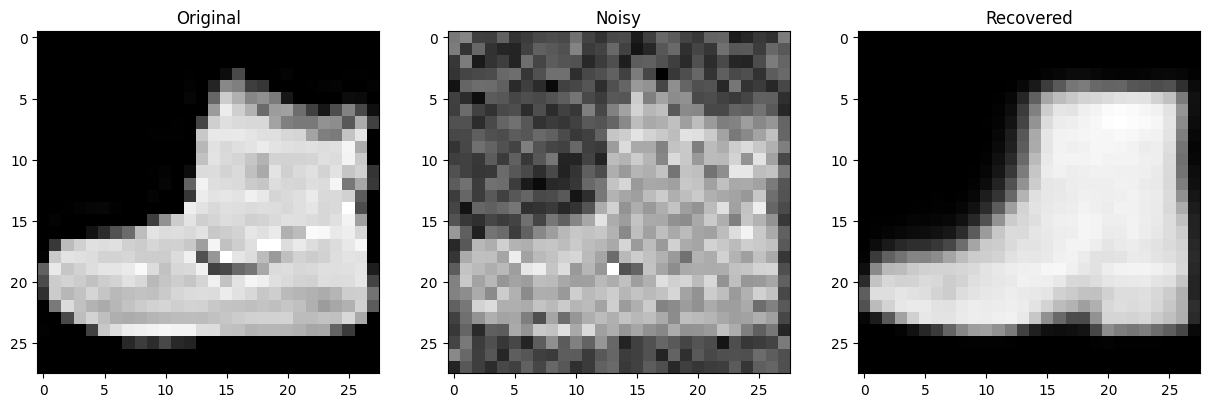

In [6]:
def add_noise(img):
    noise = torch.randn(img.size()) * 0.2
    noisy_img = img + noise
    return noisy_img

def train(autoencoder,trainloader):
    autoencoder.train()
    avg_loss = 0
    for step, (x, label) in enumerate(trainloader):
        noise_x = add_noise(x)
        noise_x = noise_x.view(-1, 28*28).to(DEVICE)
        y = x.view(-1, 28*28).to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        encoded, decoded = autoencoder(noise_x)
        loss = criterion(decoded, y)
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()
    return avg_loss / len(trainloader)

for epoch in range(1, EPOCHS+1):
    loss = train(autoencoder, trainloader)
    print("[Epoch {}] loss:{}".format(epoch, loss))

sample_data = trainset.data[0].view(-1, 28*28)
# print('before:',sample_data)
sample_data = sample_data.type(torch.FloatTensor)/255.
# print('after:',sample_data)
original_x = sample_data[0]
noisy_x = add_noise(original_x).to(DEVICE)
_, recovered_x = autoencoder(noisy_x)

f,a = plt.subplots(1,3,figsize=(15,15))
original_img = np.reshape(original_x.to("cpu").data.numpy(), (28,28))
noisy_img = np.reshape(noisy_x.to("cpu").data.numpy(), (28,28))
recovered_img = np.reshape(recovered_x.to("cpu").data.numpy(), (28,28))

a[0].set_title('Original')
a[0].imshow(original_img, cmap='gray')
a[1].set_title('Noisy')
a[1].imshow(noisy_img, cmap='gray')
a[2].set_title('Recovered')
a[2].imshow(recovered_img, cmap='gray')

plt.show()